# Deep Learning Final Project Notebook - Images Transformed into Spectral Domain + CNN

By:

Adel del Valle - ad7082

Jayanth Rao - jr6594

Joshua Alfred Jayapal - jj3811


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Loading the Dataset

loading the whole dataset as a single folder caused IO errors on Colab, and so we partitioned and compiled the dataset into 4 zip files.

In [2]:
!unzip /content/drive/MyDrive/DL_DeepFake_Dataset-001.zip -d /content/
!unzip /content/drive/MyDrive/DL_DeepFake_Dataset-002.zip -d /content/
!unzip /content/drive/MyDrive/DL_DeepFake_Dataset-003.zip -d /content/
!unzip /content/drive/MyDrive/DL_DeepFake_Dataset-004.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14110.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14092.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14086.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14081.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14072.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14135.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14071.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14078.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14057.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14068.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14125.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14062.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/see

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Preparation and Preprocessing


In [4]:
class FaceDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):

        self.real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        self.fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        min_length = min(len(self.real_images), len(self.fake_images))
        self.real_images = self.real_images[:min_length]
        self.fake_images = self.fake_images[:min_length]


        self.images = self.real_images + self.fake_images
        self.labels = [0] * min_length + [1] * min_length

        indices = np.arange(len(self.images))
        np.random.seed(42)
        np.random.shuffle(indices)

        self.images = [self.images[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]

        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

def create_dataloaders(real_dir, fake_dir, batch_size=32, num_workers=4):


    full_dataset = FaceDataset(real_dir, fake_dir)


    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size


    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )


    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )


    def check_class_balance(loader, split_name):
        class_counts = {0: 0, 1: 0}
        for _, labels in loader:
            for label in labels:
                class_counts[label.item()] += 1
        print(f"{split_name} set class balance:")
        print(f"Real faces (0): {class_counts[0]}")
        print(f"Fake faces (1): {class_counts[1]}")

    check_class_balance(train_loader, "Train")
    check_class_balance(val_loader, "Validation")
    check_class_balance(test_loader, "Test")

    return train_loader, val_loader, test_loader


## Transforming into a spectral dataset (DCT)

In [5]:
import os
import numpy as np
from PIL import Image
from scipy.fftpack import dct
import tqdm

def dct2(block):

    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def convert_image_to_dct(input_path):
    """
    Convert an image to its DCT representation

    Args:
        input_path (str): Path to input image

    Returns:
        numpy.ndarray: DCT transformed image
    """

    img = Image.open(input_path).convert('L')


    img_array = np.array(img, dtype=np.float32) / 255.0

    # 2D DCT
    dct_img = dct2(img_array)


    dct_img_normalized = ((dct_img - dct_img.min()) / (dct_img.max() - dct_img.min()) * 255).astype(np.uint8)

    return dct_img_normalized

def convert_directory_to_dct(input_dir, output_dir):

    os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    for filename in tqdm.tqdm(image_files, desc=f"Converting images in {input_dir}"):

        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        try:

            dct_img = convert_image_to_dct(input_path)
            Image.fromarray(dct_img).save(output_path)
        except Exception as e:
            print(f"Error processing {filename}: {e}")


# Directories
real_dir = '/content/DL_DeepFake_Dataset/data/real_faces'
fake_dir = '/content/DL_DeepFake_Dataset/data/fake_faces'

# Output directories
spec_real_dir = '/content/DL_DeepFake_Dataset/data/spec_real_faces'
spec_fake_dir = '/content/DL_DeepFake_Dataset/data/spec_fake_faces'


print("Converting real faces...")
convert_directory_to_dct(real_dir, spec_real_dir)


print("Converting fake faces...")
convert_directory_to_dct(fake_dir, spec_fake_dir)

print("Conversion complete!")


Converting real faces...


Converting images in /content/DL_DeepFake_Dataset/data/real_faces: 100%|██████████| 40000/40000 [06:48<00:00, 97.95it/s] 


Converting fake faces...


Converting images in /content/DL_DeepFake_Dataset/data/fake_faces: 100%|██████████| 40000/40000 [05:29<00:00, 121.35it/s]

Conversion complete!


## Visualizing DCT spectrogram of real and fake images

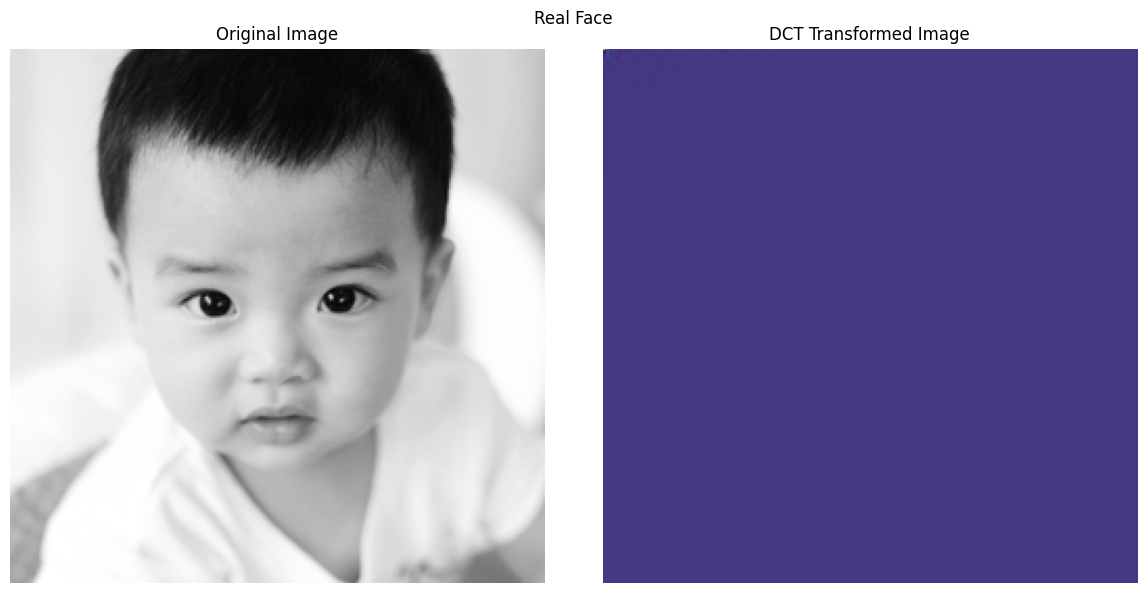

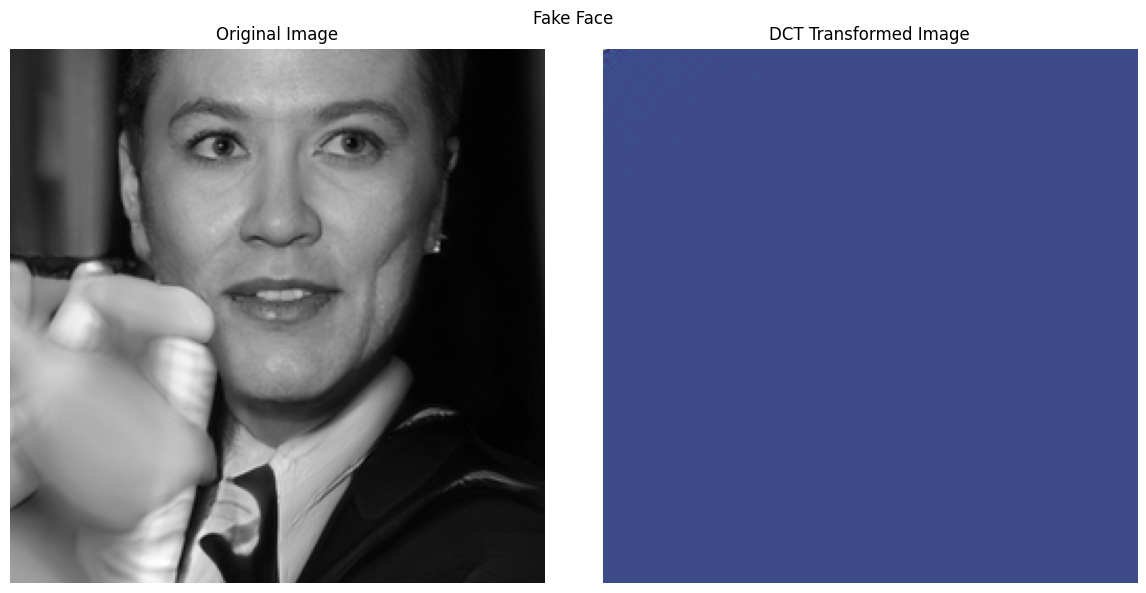

In [8]:
from PIL import Image
from scipy.fftpack import dct

def dct2(block):

    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def load_and_process_image(image_path):

    # grayscale
    img = Image.open(image_path).convert('L')


    img_array = np.array(img, dtype=np.float32) / 255.0


    dct_img = dct2(img_array)


    dct_img_normalized = ((dct_img - dct_img.min()) / (dct_img.max() - dct_img.min()) * 255).astype(np.uint8)

    return img_array, dct_img_normalized

def visualize_image_and_dct(image_path, title=None):

    original_img, dct_img = load_and_process_image(image_path)

    highlight_mask = np.ones_like(dct_img, dtype=np.float32)
    highlight_mask[:dct_img.shape[0] // 2, :dct_img.shape[1] // 2] = 0.2

    dct_img_highlighted = (dct_img * highlight_mask).astype(np.uint8)


    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.imshow(dct_img, cmap='viridis')
    plt.title('DCT Transformed Image')
    plt.axis('off')


    if title:
        plt.suptitle(title)
    else:
        plt.suptitle(f'Image: {os.path.basename(image_path)}')

    plt.tight_layout()
    plt.show()

real_dir = '/content/DL_DeepFake_Dataset/data/real_faces'
fake_dir = '/content/DL_DeepFake_Dataset/data/fake_faces'


real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

if real_images:
    visualize_image_and_dct(real_images[4], title='Real Face')

if fake_images:
    visualize_image_and_dct(fake_images[4], title='Fake Face')

In [9]:
# Dataloaders from Spectral Dataset

spec_train_loader, spec_val_loader, spec_test_loader = create_dataloaders(
    real_dir='/content/DL_DeepFake_Dataset/data/spec_real_faces',
    fake_dir='/content/DL_DeepFake_Dataset/data/spec_fake_faces',
    batch_size=32,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train set class balance:
Real faces (0): 28004
Fake faces (1): 27996
Validation set class balance:
Real faces (0): 8022
Fake faces (1): 7978
Test set class balance:
Real faces (0): 3974
Fake faces (1): 4026


## Model Architecture

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)


        self.fc1 = nn.Linear(4608, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))


        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))


        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        x = self.pool3(F.relu(self.bn6(self.conv6(x))))


        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x  # binary


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_channels = 3
num_classes = 1
model = BasicCNN().to(device)


from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 252, 252]           2,368
       BatchNorm2d-2         [-1, 16, 252, 252]              32
         MaxPool2d-3         [-1, 16, 126, 126]               0
            Conv2d-4         [-1, 32, 122, 122]          25,120
       BatchNorm2d-5         [-1, 32, 122, 122]              64
         MaxPool2d-6           [-1, 32, 61, 61]               0
            Conv2d-7           [-1, 64, 59, 59]          51,264
       BatchNorm2d-8           [-1, 64, 59, 59]             128
         MaxPool2d-9           [-1, 64, 29, 29]               0
           Conv2d-10          [-1, 128, 27, 27]         204,928
      BatchNorm2d-11          [-1, 128, 27, 27]             256
        MaxPool2d-12          [-1, 128, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         295,168
      BatchNorm2d-14          [-1, 256,

<ipython-input-21-d4d2744c39e8>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/1750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-21-d4d2744c39e8>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 [Val]:   0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-21-d4d2744c39e8>:72: FutureWarning: `torch.cuda.

Epoch 1/50, Train Loss: 0.6939, Train Acc: 0.5083, Val Loss: 0.6919, Val Acc: 0.5199
Model saved!


Epoch 2/50 [Val]: 100%|██████████| 500/500 [00:43<00:00, 11.54it/s]


Epoch 2/50, Train Loss: 0.6592, Train Acc: 0.5931, Val Loss: 0.5424, Val Acc: 0.7447
Model saved!


Epoch 3/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.71it/s]


Epoch 3/50, Train Loss: 0.4711, Train Acc: 0.7938, Val Loss: 0.3776, Val Acc: 0.8436
Model saved!


Epoch 4/50 [Val]: 100%|██████████| 500/500 [00:43<00:00, 11.59it/s]


Epoch 4/50, Train Loss: 0.3598, Train Acc: 0.8562, Val Loss: 0.2939, Val Acc: 0.8814
Model saved!


Epoch 5/50 [Val]: 100%|██████████| 500/500 [00:45<00:00, 10.94it/s]


Epoch 5/50, Train Loss: 0.3006, Train Acc: 0.8844, Val Loss: 0.2603, Val Acc: 0.8997
Model saved!


Epoch 6/50 [Val]: 100%|██████████| 500/500 [00:37<00:00, 13.33it/s]


Epoch 6/50, Train Loss: 0.2660, Train Acc: 0.9003, Val Loss: 0.2352, Val Acc: 0.9098
Model saved!


Epoch 7/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.87it/s]


Epoch 7/50, Train Loss: 0.2410, Train Acc: 0.9119, Val Loss: 0.2118, Val Acc: 0.9204
Model saved!


Epoch 8/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.71it/s]


Epoch 8/50, Train Loss: 0.2209, Train Acc: 0.9191, Val Loss: 0.2021, Val Acc: 0.9223
Model saved!


Epoch 9/50 [Val]: 100%|██████████| 500/500 [00:44<00:00, 11.12it/s]


Epoch 9/50, Train Loss: 0.2053, Train Acc: 0.9256, Val Loss: 0.1888, Val Acc: 0.9296
Model saved!


Epoch 10/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.02it/s]


Epoch 10/50, Train Loss: 0.1939, Train Acc: 0.9301, Val Loss: 0.1835, Val Acc: 0.9317
Model saved!


Epoch 11/50 [Val]: 100%|██████████| 500/500 [00:43<00:00, 11.56it/s]


Epoch 11/50, Train Loss: 0.1846, Train Acc: 0.9352, Val Loss: 0.1681, Val Acc: 0.9373
Model saved!


Epoch 12/50 [Val]: 100%|██████████| 500/500 [00:43<00:00, 11.52it/s]


Epoch 12/50, Train Loss: 0.1752, Train Acc: 0.9382, Val Loss: 0.1692, Val Acc: 0.9354


Epoch 13/50 [Val]: 100%|██████████| 500/500 [00:38<00:00, 13.04it/s]


Epoch 13/50, Train Loss: 0.1683, Train Acc: 0.9401, Val Loss: 0.1579, Val Acc: 0.9420
Model saved!


Epoch 14/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.06it/s]


Epoch 14/50, Train Loss: 0.1592, Train Acc: 0.9440, Val Loss: 0.1632, Val Acc: 0.9401


Epoch 15/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.84it/s]


Epoch 15/50, Train Loss: 0.1527, Train Acc: 0.9464, Val Loss: 0.1471, Val Acc: 0.9459
Model saved!


Epoch 16/50 [Val]: 100%|██████████| 500/500 [00:37<00:00, 13.41it/s]


Epoch 16/50, Train Loss: 0.1476, Train Acc: 0.9489, Val Loss: 0.1595, Val Acc: 0.9391


Epoch 17/50 [Val]: 100%|██████████| 500/500 [00:43<00:00, 11.37it/s]


Epoch 17/50, Train Loss: 0.1418, Train Acc: 0.9508, Val Loss: 0.1399, Val Acc: 0.9483
Model saved!


Epoch 18/50 [Val]: 100%|██████████| 500/500 [00:39<00:00, 12.52it/s]


Epoch 18/50, Train Loss: 0.1364, Train Acc: 0.9535, Val Loss: 0.1373, Val Acc: 0.9503
Model saved!


Epoch 19/50 [Val]: 100%|██████████| 500/500 [00:38<00:00, 13.14it/s]


Epoch 19/50, Train Loss: 0.1330, Train Acc: 0.9554, Val Loss: 0.1335, Val Acc: 0.9506
Model saved!


Epoch 20/50 [Val]: 100%|██████████| 500/500 [00:39<00:00, 12.78it/s]


Epoch 20/50, Train Loss: 0.1289, Train Acc: 0.9560, Val Loss: 0.1333, Val Acc: 0.9507
Model saved!


Epoch 21/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.73it/s]


Epoch 21/50, Train Loss: 0.1237, Train Acc: 0.9575, Val Loss: 0.1303, Val Acc: 0.9526
Model saved!


Epoch 22/50 [Val]: 100%|██████████| 500/500 [00:43<00:00, 11.59it/s]


Epoch 22/50, Train Loss: 0.1195, Train Acc: 0.9583, Val Loss: 0.1381, Val Acc: 0.9501


Epoch 23/50 [Val]: 100%|██████████| 500/500 [00:43<00:00, 11.61it/s]


Epoch 23/50, Train Loss: 0.1163, Train Acc: 0.9601, Val Loss: 0.1291, Val Acc: 0.9531
Model saved!


Epoch 24/50 [Val]: 100%|██████████| 500/500 [00:40<00:00, 12.49it/s]


Epoch 24/50, Train Loss: 0.1109, Train Acc: 0.9634, Val Loss: 0.1265, Val Acc: 0.9543
Model saved!


Epoch 25/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 11.93it/s]


Epoch 25/50, Train Loss: 0.1100, Train Acc: 0.9627, Val Loss: 0.1273, Val Acc: 0.9536


Epoch 26/50 [Val]: 100%|██████████| 500/500 [00:38<00:00, 13.02it/s]


Epoch 26/50, Train Loss: 0.1050, Train Acc: 0.9645, Val Loss: 0.1300, Val Acc: 0.9543


Epoch 27/50 [Val]: 100%|██████████| 500/500 [00:40<00:00, 12.43it/s]


Epoch 27/50, Train Loss: 0.1023, Train Acc: 0.9653, Val Loss: 0.1272, Val Acc: 0.9521


Epoch 28/50 [Val]: 100%|██████████| 500/500 [00:45<00:00, 11.04it/s]


Epoch 28/50, Train Loss: 0.0991, Train Acc: 0.9664, Val Loss: 0.1386, Val Acc: 0.9486


Epoch 29/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.13it/s]


Epoch 29/50, Train Loss: 0.0943, Train Acc: 0.9679, Val Loss: 0.1288, Val Acc: 0.9572


Epoch 30/50 [Val]: 100%|██████████| 500/500 [00:40<00:00, 12.47it/s]


Epoch 30/50, Train Loss: 0.0928, Train Acc: 0.9683, Val Loss: 0.1227, Val Acc: 0.9567
Model saved!


Epoch 31/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.11it/s]


Epoch 31/50, Train Loss: 0.0912, Train Acc: 0.9696, Val Loss: 0.1319, Val Acc: 0.9546


Epoch 32/50 [Val]: 100%|██████████| 500/500 [00:39<00:00, 12.75it/s]


Epoch 32/50, Train Loss: 0.0872, Train Acc: 0.9710, Val Loss: 0.1331, Val Acc: 0.9554


Epoch 33/50 [Val]: 100%|██████████| 500/500 [00:39<00:00, 12.68it/s]


Epoch 33/50, Train Loss: 0.0835, Train Acc: 0.9724, Val Loss: 0.1603, Val Acc: 0.9492


Epoch 34/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.17it/s]


Epoch 34/50, Train Loss: 0.0800, Train Acc: 0.9732, Val Loss: 0.1334, Val Acc: 0.9564


Epoch 35/50 [Val]: 100%|██████████| 500/500 [00:39<00:00, 12.52it/s]


Epoch 35/50, Train Loss: 0.0778, Train Acc: 0.9744, Val Loss: 0.1267, Val Acc: 0.9581


Epoch 36/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.09it/s]


Epoch 36/50, Train Loss: 0.0753, Train Acc: 0.9753, Val Loss: 0.1294, Val Acc: 0.9578


Epoch 37/50 [Val]: 100%|██████████| 500/500 [00:45<00:00, 10.97it/s]


Epoch 37/50, Train Loss: 0.0726, Train Acc: 0.9762, Val Loss: 0.1377, Val Acc: 0.9566


Epoch 38/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.80it/s]


Epoch 38/50, Train Loss: 0.0692, Train Acc: 0.9773, Val Loss: 0.1286, Val Acc: 0.9572


Epoch 39/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.86it/s]


Epoch 39/50, Train Loss: 0.0673, Train Acc: 0.9775, Val Loss: 0.1273, Val Acc: 0.9576


Epoch 40/50 [Val]: 100%|██████████| 500/500 [00:39<00:00, 12.50it/s]


Epoch 40/50, Train Loss: 0.0656, Train Acc: 0.9789, Val Loss: 0.1322, Val Acc: 0.9558


Epoch 41/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.09it/s]


Epoch 41/50, Train Loss: 0.0630, Train Acc: 0.9796, Val Loss: 0.1310, Val Acc: 0.9573


Epoch 42/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.03it/s]


Epoch 42/50, Train Loss: 0.0607, Train Acc: 0.9806, Val Loss: 0.1381, Val Acc: 0.9579


Epoch 43/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 11.94it/s]


Epoch 43/50, Train Loss: 0.0583, Train Acc: 0.9812, Val Loss: 0.1570, Val Acc: 0.9523


Epoch 44/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.66it/s]


Epoch 44/50, Train Loss: 0.0550, Train Acc: 0.9827, Val Loss: 0.1420, Val Acc: 0.9584


Epoch 45/50 [Val]: 100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Epoch 45/50, Train Loss: 0.0542, Train Acc: 0.9829, Val Loss: 0.1531, Val Acc: 0.9542


Epoch 46/50 [Val]: 100%|██████████| 500/500 [00:43<00:00, 11.37it/s]


Epoch 46/50, Train Loss: 0.0500, Train Acc: 0.9843, Val Loss: 0.1452, Val Acc: 0.9576


Epoch 47/50 [Val]: 100%|██████████| 500/500 [00:40<00:00, 12.27it/s]


Epoch 47/50, Train Loss: 0.0492, Train Acc: 0.9849, Val Loss: 0.1539, Val Acc: 0.9576


Epoch 48/50 [Val]: 100%|██████████| 500/500 [00:41<00:00, 12.03it/s]


Epoch 48/50, Train Loss: 0.0468, Train Acc: 0.9854, Val Loss: 0.1461, Val Acc: 0.9566


Epoch 49/50 [Val]: 100%|██████████| 500/500 [00:44<00:00, 11.24it/s]


Epoch 49/50, Train Loss: 0.0442, Train Acc: 0.9867, Val Loss: 0.1841, Val Acc: 0.9494


Epoch 50/50 [Val]: 100%|██████████| 500/500 [00:40<00:00, 12.40it/s]


Epoch 50/50, Train Loss: 0.0419, Train Acc: 0.9869, Val Loss: 0.1530, Val Acc: 0.9567


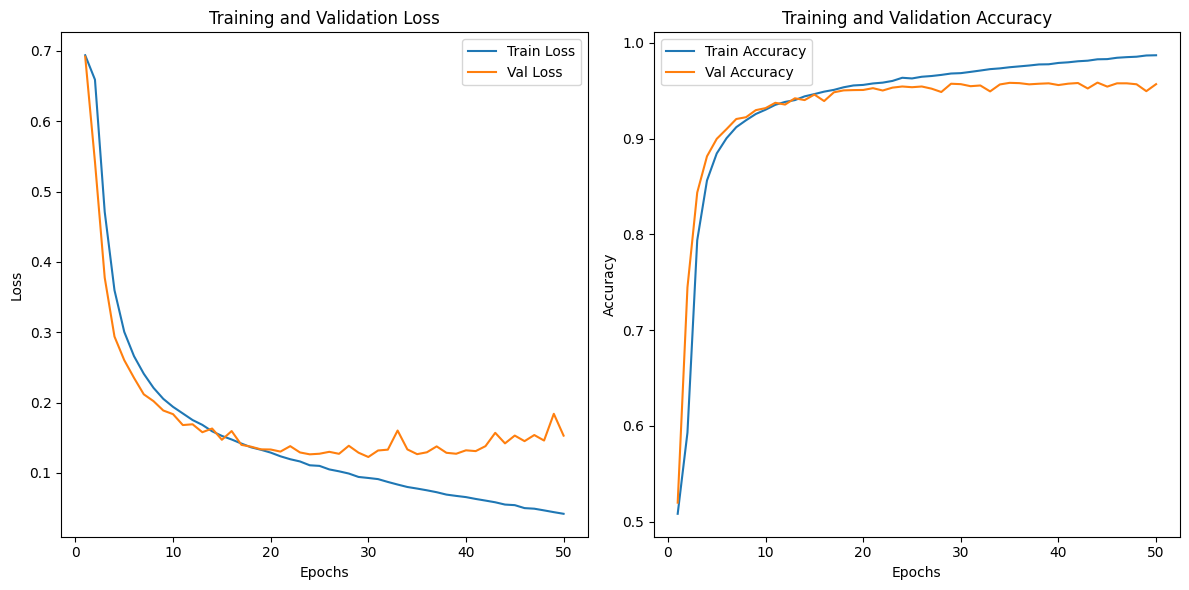

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=2e-5, weight_decay=1e-5)

from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []


epochs = 50
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(spec_train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()


        with autocast():

            outputs = model(images).to(device)
            loss = criterion(outputs, labels)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()


        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(spec_train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    torch.cuda.empty_cache()

    val_pbar = tqdm(spec_val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            with autocast():
                outputs = model(images).to(device)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

    val_loss /= len(spec_val_loader)
    val_accuracy = correct_val / total_val

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_dpfk_model_CNN_final.pth")
        print("Model saved!")


epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

from google.colab import files

files.download('best_dpfk_model_CNN_final.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-27-ed39d3498f27>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_dpfk_model_CNN_final.pth"))
/usr/local/lib/python3.10

Test Accuracy: 95.43%


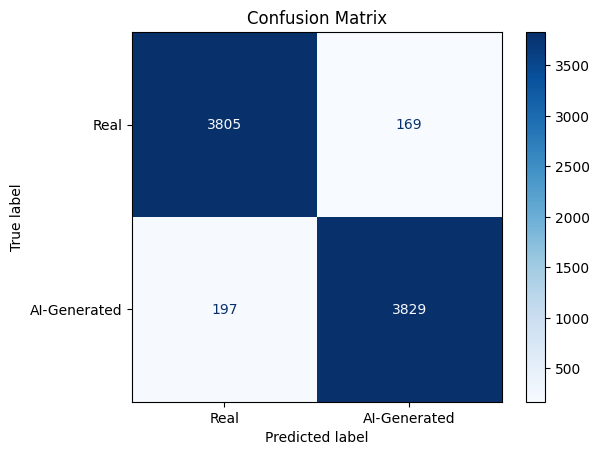

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)
model.load_state_dict(torch.load("best_dpfk_model_CNN_final.pth"))
model.eval()

# Test loop
def evaluate_model(model, test_loader, threshold=0.5):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > threshold
            correct += (predictions.squeeze() == labels).sum().item()
            total += labels.size(0)


            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return np.array(all_preds), np.array(all_labels)


def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "AI-Generated"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


all_preds, all_labels = evaluate_model(model, spec_test_loader)
plot_confusion_matrix(all_labels, all_preds)

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
def calculate_metrics(all_labels, all_preds):

    binary_preds = (all_preds > 0.5).astype(int)

    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)

    auc = roc_auc_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")

calculate_metrics(all_labels, all_preds)

Precision: 0.9577
Recall: 0.9511
AUC: 0.9543


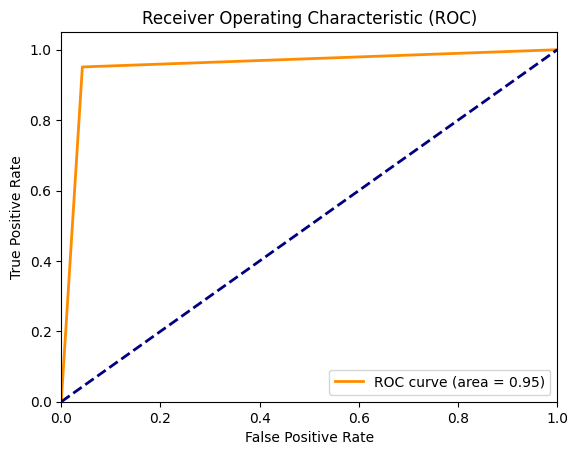

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(all_labels, all_preds):
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(all_labels, all_preds)

In [48]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from datetime import datetime
def predict_and_display(model, image_path, device):

    model.eval()

    original_img = Image.open(image_path)


    preprocess = Compose([
        Resize((256, 256)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dct_img = convert_image_to_dct(image_path)
    dct_img = np.expand_dims(dct_img, axis=0)

    dct_img_rgb = np.repeat(dct_img, 3, axis=0)
    dct_img_rgb = np.transpose(dct_img_rgb, (1, 2, 0)).astype(np.uint8)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    saved_path = f"/content/dct_image_{timestamp}.png"

    Image.fromarray(dct_img_rgb, mode="RGB").save(saved_path)
    image = Image.open(saved_path)


    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        sigmoid_score = torch.sigmoid(output).item()
        prediction = 1 if sigmoid_score > 0.5 else 0

    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"Sigmoid Score: {sigmoid_score:.4f}\nPrediction: {prediction}")
    plt.show()

<ipython-input-49-7ca2d1c5ed87>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_dpfk_model_CNN_final.pth"))


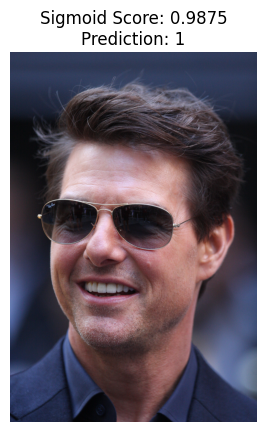

In [49]:
# make sure the model is loaded

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)
model.load_state_dict(torch.load("/content/best_dpfk_model_CNN_final.pth"))

from PIL import Image
sample_image = '/content/Tom_Cruise_(34450932580).jpg'
predict_and_display(model, sample_image, device)

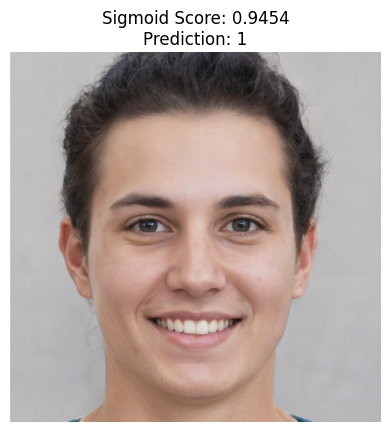

In [52]:
sample_image = '/content/Screenshot 2024-12-12 at 12.19.18 AM.jpg'
predict_and_display(model, sample_image, device)

However, the model trained on the spectral images has identified noisy artifacts within its spectral domain, and has rendered this image as a fake, which is correct according to: https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html
